In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings
warnings.filterwarnings("ignore")

In [2]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

In [3]:
user_info = pd.read_csv(r'filled_data/filled_user_info.csv')
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         424170 non-null  int64
 1   age             424170 non-null  int64
 2   sex             424170 non-null  int64
 3   job             424170 non-null  int64
 4   carrier         424170 non-null  int64
 5   marital_status  424170 non-null  int64
dtypes: int64(6)
memory usage: 19.4 MB


In [4]:
user_info.head()

,user_id,age,sex,job,carrier,marital_status
0,376517,44,1,48,1,1
1,234512,39,0,51,2,1
2,344532,39,0,9,1,1
3,186135,37,0,48,2,1
4,30230,38,0,9,3,1


In [5]:
user_log = pd.read_csv(r'filled_data/filled_user_log.csv')
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   brand_id     float64
 4   merchant_id  int64  
 5   action       object 
 6   datetime     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.9+ GB


In [6]:
user_log.head()

,user_id,item_id,cat_id,brand_id,merchant_id,action,datetime
0,328862,323294,833,2661.0,2882,click,2024-08-29
1,328862,844400,1271,2661.0,2882,click,2024-08-29
2,328862,575153,1271,2661.0,2882,click,2024-08-29
3,328862,996875,1271,2661.0,2882,click,2024-08-29
4,328862,1086186,1271,1049.0,1253,click,2024-08-29


In [7]:
train = pd.read_csv(r'cleaned_data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215555 entries, 0 to 215554
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      215555 non-null  float64
 1   merchant_id  215555 non-null  float64
 2   label        215555 non-null  float64
dtypes: float64(3)
memory usage: 4.9 MB


In [8]:
train.head()

,user_id,merchant_id,label
0,393595.0,794.0,0.0
1,287580.0,2447.0,0.0
2,203618.0,598.0,0.0
3,143560.0,2030.0,0.0
4,324173.0,1875.0,0.0


In [9]:
test = pd.read_csv(r'cleaned_data/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52695 entries, 0 to 52694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      52695 non-null  int64
 1   merchant_id  52695 non-null  int64
 2   label        52695 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


In [10]:
test.head()

,user_id,merchant_id,label
0,52307,1393,0
1,182730,1890,0
2,92119,423,0
3,339138,4129,0
4,121953,2821,0


## **Preprocessing train data**

In [11]:
train['label'].value_counts()

label
 0.0    196138
 1.0     14639
-1.0      4778
Name: count, dtype: int64

In [12]:
# Drop row have label -1
train = train[train['label'] != -1]

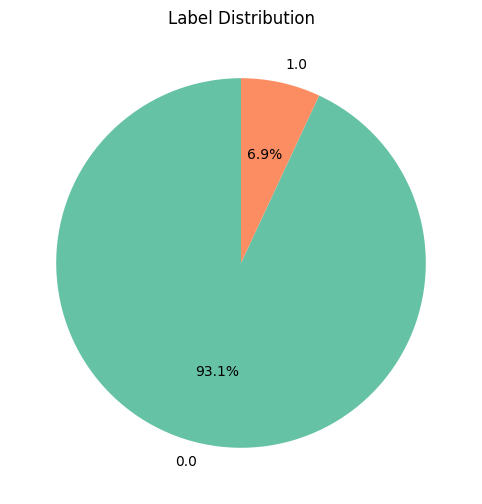

In [13]:
# Pie chart of label distribution
plt.figure(figsize=(8, 6))
train['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

## **Preprocessing test data**

In [14]:
test['label'].value_counts()

label
0    49035
1     3660
Name: count, dtype: int64

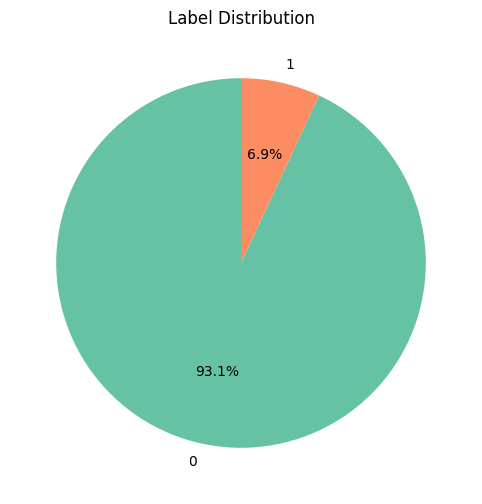

In [15]:
# Pie chart of label distribution
plt.figure(figsize=(8, 6))
test['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

## **`user_log` Data Aggregation**

In [ ]:
# Count the number of each action type per (user_id, merchant_id) pair
action_counts = user_log.groupby(['user_id', 'merchant_id', 'action']).size().unstack(fill_value=0)
action_counts = action_counts.reset_index()

# Aggregate unique counts and date statistics per (user_id, merchant_id) pair
unique_counts = user_log.groupby(['user_id', 'merchant_id']).agg({
    'item_id': 'nunique',       # Number of unique items interacted with
    'cat_id': 'nunique',        # Number of unique categories
    'brand_id': 'nunique',      # Number of unique brands
    'datetime': ['nunique',     # Number of unique activity days
                 'min',         # First activity date
                 'max']         # Last activity date
}).reset_index()

# Flatten the MultiIndex column names
unique_counts.columns = [
    'user_id', 'merchant_id',
    'unique_items', 'unique_cats', 'unique_brands',
    'unique_dates', 'first_date', 'last_date'
]

# Calculate activity duration (range of days between first and last interaction)
unique_counts['date_range'] = (
    pd.to_datetime(unique_counts['last_date']) -
    pd.to_datetime(unique_counts['first_date'])
).dt.days

# Drop the original date columns after calculating date_range
unique_counts = unique_counts.drop(columns=['first_date', 'last_date'])

# Calculate conversion rate as purchase / total actions
unique_counts['conversion_rate'] = (
    action_counts['purchase'] /
    (action_counts['click'] + action_counts['purchase'] +
     action_counts['add-to-cart'] + action_counts['favourite'])
)

# Merge action counts and aggregated unique features into final feature set
features = action_counts.merge(unique_counts, on=['user_id', 'merchant_id'], how='left')

features


,user_id,merchant_id,add-to-cart,click,favourite,purchase,unique_items,unique_cats,unique_brands,unique_dates,date_range,conversion_rate
0,1,471,0,1,0,0,1,1,1,1,0,0.000000
1,1,739,0,1,0,0,1,1,1,1,0,0.000000
2,1,925,0,3,0,1,1,1,1,1,0,0.250000
3,1,1019,0,10,0,4,1,1,1,1,0,0.285714
4,1,1156,0,1,0,0,1,1,1,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
14058661,424170,1082,0,1,0,0,1,1,1,1,0,0.000000
14058662,424170,3469,0,1,0,0,1,1,1,1,0,0.000000
14058663,424170,3736,0,10,0,0,7,2,1,1,0,0.000000
14058664,424170,4268,0,24,0,1,3,1,1,5,6,0.040000


## **`train` Data Aggregation**

In [17]:
train = train.merge(user_info, on='user_id', how='inner')
train = train.merge(features, on=['user_id', 'merchant_id'], how='inner')

train

,user_id,merchant_id,label,age,sex,job,carrier,marital_status,add-to-cart,click,favourite,purchase,unique_items,unique_cats,unique_brands,unique_dates,date_range,conversion_rate
0,393595.0,794.0,0.0,27,0,39,3,0,0,9,2,2,5,1,1,6,12,0.153846
1,287580.0,2447.0,0.0,27,0,45,1,1,0,5,0,1,1,1,1,1,0,0.166667
2,203618.0,598.0,0.0,26,0,24,3,1,0,6,0,2,3,2,2,1,0,0.250000
3,143560.0,2030.0,0.0,27,0,7,0,0,0,1,0,1,1,1,1,1,0,0.500000
4,324173.0,1875.0,0.0,32,0,51,0,1,0,48,0,1,23,7,1,3,171,0.020408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208683,3912.0,2872.0,0.0,31,0,21,3,1,0,6,0,3,4,3,3,1,0,0.333333
208684,255388.0,3022.0,0.0,31,1,37,0,1,0,0,0,1,1,1,1,1,0,1.000000
208685,299696.0,2193.0,0.0,18,0,47,3,2,0,3,0,1,3,1,1,1,0,0.250000
208686,57682.0,66.0,0.0,22,1,50,2,2,1,28,2,1,5,1,1,5,7,0.031250


## **`test` Data Aggregation**

In [18]:
test = test.merge(user_info, on='user_id', how='inner')
test = test.merge(features, on=['user_id', 'merchant_id'], how='inner')

test

,user_id,merchant_id,label,age,sex,job,carrier,marital_status,add-to-cart,click,favourite,purchase,unique_items,unique_cats,unique_brands,unique_dates,date_range,conversion_rate
0,52307,1393,0,26,0,8,0,1,0,10,0,1,5,3,1,4,140,0.090909
1,182730,1890,0,28,0,13,2,2,1,11,2,1,4,2,2,3,5,0.066667
2,92119,423,0,27,0,36,2,1,0,0,0,1,1,1,1,1,0,1.000000
3,339138,4129,0,25,0,13,0,1,0,23,0,8,19,5,1,2,1,0.258065
4,121953,2821,0,27,0,1,2,1,0,2,0,1,1,1,1,1,0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52171,1925,3266,0,22,0,13,1,2,0,1,0,1,1,1,1,1,0,0.500000
52172,55363,4079,0,31,0,10,1,1,0,23,1,2,15,4,2,2,5,0.076923
52173,68457,742,0,27,0,18,3,0,0,2,0,1,1,1,1,1,0,0.333333
52174,15500,4589,0,26,0,38,4,1,0,1,0,1,1,1,1,1,0,0.500000


## **Data Aggregation for Clustering**

In [ ]:
user_log['datetime'] = pd.to_datetime(user_log['datetime'])

# Find the most recent timestamp in the entire log
latest_log_time = user_log['datetime'].max()

# Aggregate user behavior
user_behavior = user_log.groupby('user_id').agg({
    'action': 'count',                        # Total number of actions
    'item_id': pd.Series.nunique,            # Number of unique items
    'cat_id': pd.Series.nunique,             # Number of unique categories
    'brand_id': pd.Series.nunique,           # Number of unique brands
    'merchant_id': pd.Series.nunique,        # Number of unique merchants
    'datetime': [
        lambda x: (latest_log_time - x.max()).days,  # Recency (days since last activity)
        lambda x: x.dt.date.nunique(),               # Number of unique active days
        lambda x: x.min(),                           # First activity date
        lambda x: x.max()                            # Last activity date
    ]
})

# Rename columns for clarity
user_behavior.columns = [
    'total_actions',
    'unique_items',
    'unique_categories',
    'unique_brands',
    'unique_merchants',
    'recency_days',
    'active_days',
    'first_date',
    'last_date'
]

# Count actions by type using pivot table
action_counts = user_log.pivot_table(
    index='user_id',
    columns='action',
    aggfunc='size',
    fill_value=0
)

# Calculate conversion rate (purchase actions / total actions)
conversion_rate = action_counts.get('purchase', 0) / user_behavior['total_actions']
user_behavior['conversion_rate'] = conversion_rate.fillna(0)

# Calculate the range of activity in days
user_behavior['date_range'] = (
    pd.to_datetime(user_behavior['last_date']) - 
    pd.to_datetime(user_behavior['first_date'])
).dt.days

# Reset index so user_id becomes a column
user_behavior = user_behavior.reset_index()

# Merge user behavior with action counts
user_behavior = user_behavior.merge(action_counts, on='user_id', how='inner')

user_behavior

,user_id,total_actions,unique_items,unique_categories,unique_brands,unique_merchants,recency_days,active_days,first_date,last_date,conversion_rate,date_range,add-to-cart,click,favourite,purchase
0,1,33,12,6,9,9,1,5,2024-10-09,2024-11-11,0.181818,33,0,27,0,6
1,2,63,43,14,15,14,1,9,2024-05-27,2024-11-11,0.222222,168,0,47,2,14
2,3,68,45,19,22,23,1,13,2024-05-16,2024-11-11,0.058824,179,0,63,1,4
3,4,50,28,13,12,12,1,10,2024-05-27,2024-11-11,0.020000,168,0,49,0,1
4,5,173,87,40,60,56,1,30,2024-05-19,2024-11-11,0.075145,176,0,150,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424165,424166,90,48,12,23,22,1,12,2024-05-14,2024-11-11,0.122222,181,0,79,0,11
424166,424167,35,15,9,9,12,1,8,2024-05-29,2024-11-11,0.171429,166,0,28,1,6
424167,424168,223,160,48,97,112,1,55,2024-05-23,2024-11-11,0.026906,172,0,216,1,6
424168,424169,297,176,46,103,102,1,34,2024-05-11,2024-11-11,0.057239,184,0,277,3,17


In [20]:
final_data = user_info.merge(user_behavior, on='user_id', how='inner')
columns = [
    'age',
    'sex',
    'job',
    'carrier',
    'marital_status',
    "total_actions",
    "unique_items",
    "unique_categories",
    "unique_brands",
    "unique_merchants",
    "recency_days",
    "active_days",
    "conversion_rate",
    "date_range",
    "add-to-cart",
    "click",
    "favourite",
    "purchase"
]
final_data = final_data[columns] 
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                424170 non-null  int64  
 1   sex                424170 non-null  int64  
 2   job                424170 non-null  int64  
 3   carrier            424170 non-null  int64  
 4   marital_status     424170 non-null  int64  
 5   total_actions      424170 non-null  int64  
 6   unique_items       424170 non-null  int64  
 7   unique_categories  424170 non-null  int64  
 8   unique_brands      424170 non-null  int64  
 9   unique_merchants   424170 non-null  int64  
 10  recency_days       424170 non-null  int64  
 11  active_days        424170 non-null  int64  
 12  conversion_rate    424170 non-null  float64
 13  date_range         424170 non-null  int64  
 14  add-to-cart        424170 non-null  int64  
 15  click              424170 non-null  int64  
 16  fa

## **Heatmap of corelation matrix**

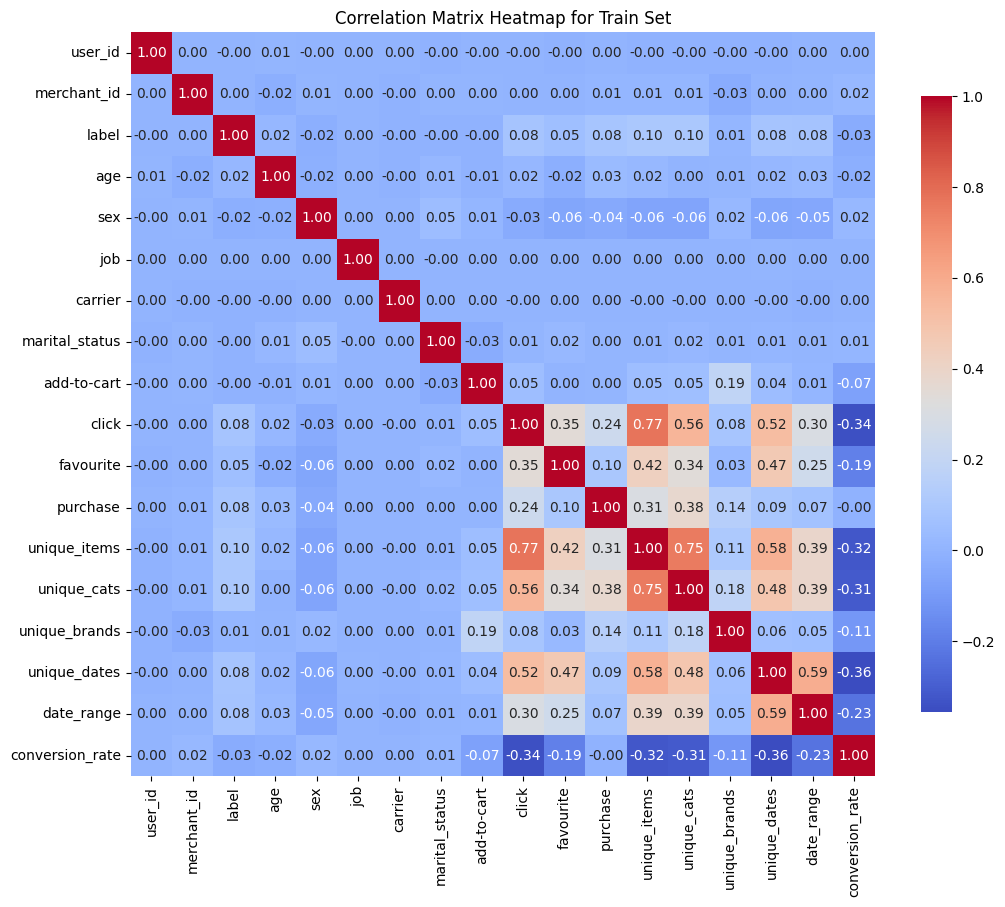

In [21]:
# Heat map of correlation matrix for train set
plt.figure(figsize=(12, 10))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap for Train Set')
plt.show()

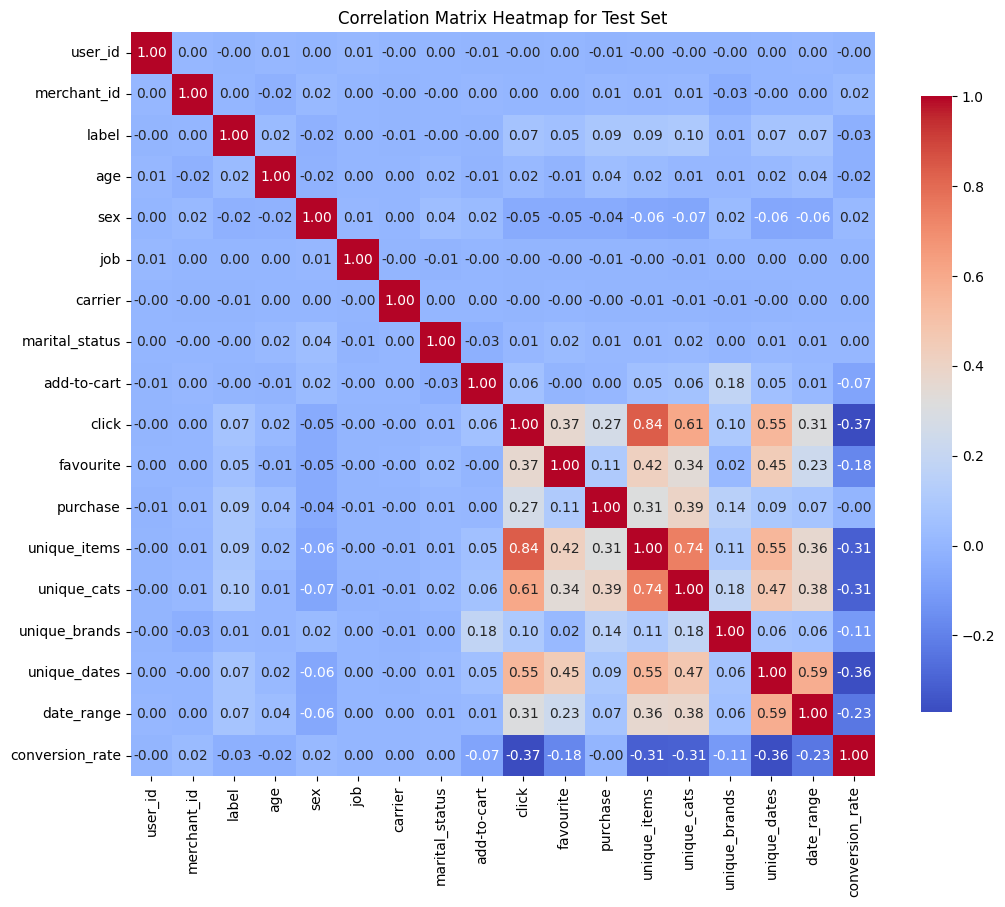

In [22]:
# Heat map of correlation matrix for test set
plt.figure(figsize=(12, 10))
correlation_matrix_test = test.corr()
sns.heatmap(correlation_matrix_test, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap for Test Set')
plt.show()

# **Classification Model**

In [23]:
class Predictor:
    def __init__(self, X_train, X_test, Y_train, Y_test):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

        self.configs = {
            'random_forest': {'n_estimators': 100, 'criterion': 'gini', 'max_depth': None},
            'xgboost': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3},
            'lightgbm': {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31},
            'catboost': {'iterations': 100, 'learning_rate': 0.1, 'depth': 6}
        }

        self.param_grids = {
            'random_forest': {'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [None] + list(range(1, 21))},
            'xgboost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': list(range(3, 10))},
            'lightgbm': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 63]},
            'catboost': {'iterations': [50, 100], 'learning_rate': [0.01, 0.1], 'depth': list(range(3, 10))}
        }
        
    def create_model(self, model_name):
        if model_name not in self.configs:
            raise ValueError(f"Model {model_name} is not defined in configs.")
        try:
            model_class = {
                'random_forest': RandomForestClassifier,
                'xgboost': xgb.XGBClassifier,
                'lightgbm': lgb.LGBMClassifier,
                'catboost': cb.CatBoostClassifier
            }[model_name]
            return model_class(**self.configs[model_name])
        except KeyError:
            raise ValueError(f"Model {model_name} is not recognized.")

    def run_model(self, model_name, threshold=False):
        best_threshold = 0.5
        best_f1 = 0.0
        Y_pred = None
        model = self.create_model(model_name)
        model.fit(self.X_train, self.Y_train)
        if threshold is False:
            Y_pred = model.predict(self.X_test)
        else:
            for threshold in np.arange(0.1, 1.0, 0.1):
                probs = model.predict_proba(self.X_test)[:, 1]
                Y_pred_tmp = (probs >= threshold).astype(int)
                f1 = f1_score(self.Y_test, Y_pred_tmp)
                print(f"F1 score for threshold {threshold}: {f1}")
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    Y_pred = Y_pred_tmp
            print(f"Best threshold for {model_name}: {best_threshold} with F1 score: {best_f1}")

        tn, fp, fn, tp = confusion_matrix(self.Y_test, Y_pred).ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        print(f"Model: {model_name}")
        print('Config:', self.configs[model_name])
        print('Accuracy:', accuracy_score(self.Y_test, Y_pred))
        print('F1 score:', f1_score(self.Y_test, Y_pred))
        print('FNR:', fnr)
        
        # Confusion matrix plot
        cm = confusion_matrix(self.Y_test, Y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        

    def update_config(self, model_name, new_config):
        if model_name in self.configs:
            self.configs[model_name] = {**self.configs[model_name], **new_config}
        return self.create_model(model_name)
    
    def random_search(self, model_name, cv=5, scoring='f1', verbose=1, n_iter=30, random_state=42):
        if model_name not in self.configs:
                raise ValueError(f"Model '{model_name}' not recognized. Available models: {list(self.configs.keys())}")
    
        model = self.create_model(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found in the class instance.")
    
        param_distributions = self.param_grids.get(model_name, None)
        if param_distributions is None:
            raise ValueError(f"No parameter grid defined for model '{model_name}'.")
    
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=verbose,
            random_state=random_state
        )
    
        print(f"Starting Randomized Search for model '{model_name}'...")
        randomized_search.fit(self.X_train, self.Y_train)
    
        best_params = randomized_search.best_params_
        best_score = randomized_search.best_score_
    
        print(f"Best Parameters for {model_name}: {best_params}")
        print(f"Best Cross-Validation {scoring}: {best_score:.4f}")

        return self.update_config(model_name, best_params)

In [24]:
columns = ['click', 'add-to-cart', 'favourite', 'purchase', 'unique_items', 'unique_cats', 'unique_brands', 'unique_dates', 'date_range', 'conversion_rate']
X_train = train[columns]
Y_train = train['label']
X_test = test[columns]
Y_test = test['label']

## **SMOTE approach**

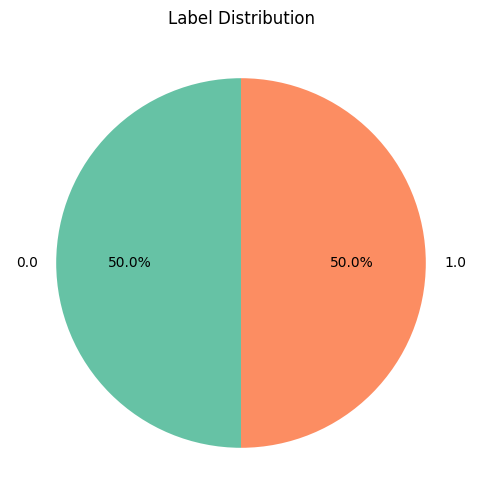

In [25]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

plt.figure(figsize=(8, 6))
Y_train_resampled.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

In [26]:
predictor = Predictor(X_train_resampled, X_test, Y_train_resampled, Y_test)

Starting Randomized Search for model 'random_forest'...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for random_forest: {'n_estimators': 50, 'max_depth': None, 'criterion': 'gini'}
Best Cross-Validation f1: 0.7204
Model: random_forest
Config: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None}
Accuracy: 0.8287910150260657
F1 score: 0.10230127625364285
FNR: 0.8401381909547738


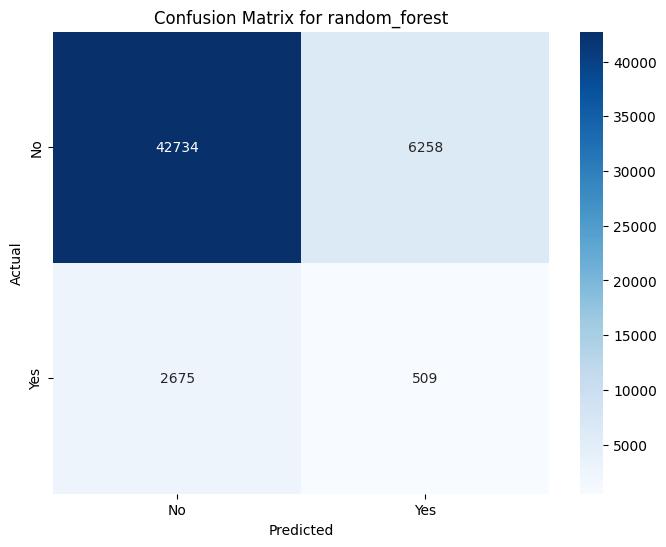

In [27]:
predictor.random_search('random_forest')
predictor.run_model('random_forest')

Starting Randomized Search for model 'xgboost'...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for xgboost: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2}
Best Cross-Validation f1: 0.6680
Model: xgboost
Config: {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 9}
Accuracy: 0.8266827660226924
F1 score: 0.1231455444584505
FNR: 0.8005653266331658


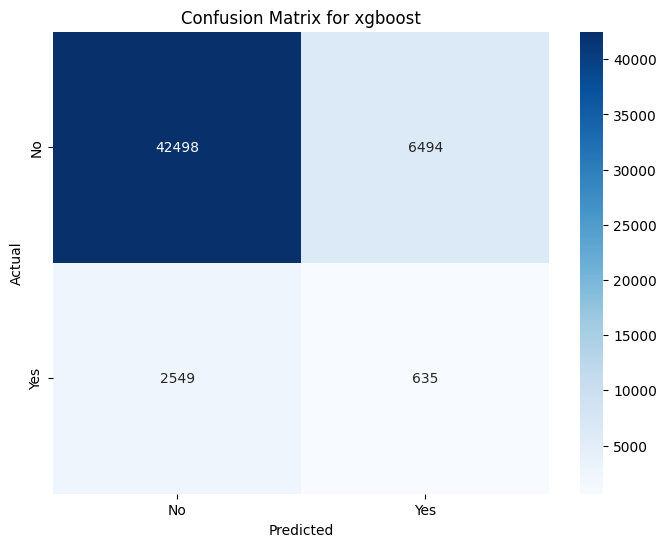

In [28]:
predictor.random_search('xgboost')
predictor.run_model('xgboost')

Starting Randomized Search for model 'lightgbm'...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 195920, number of negative: 195920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 391840, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters for lightgbm: {'num_leaves': 63, 'n_estimators': 200, 'learning_rate': 0.2}
Best Cross-Validation f1: 0.6661
[LightGBM] [Info] Number of positive: 195920, number of negative: 195920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

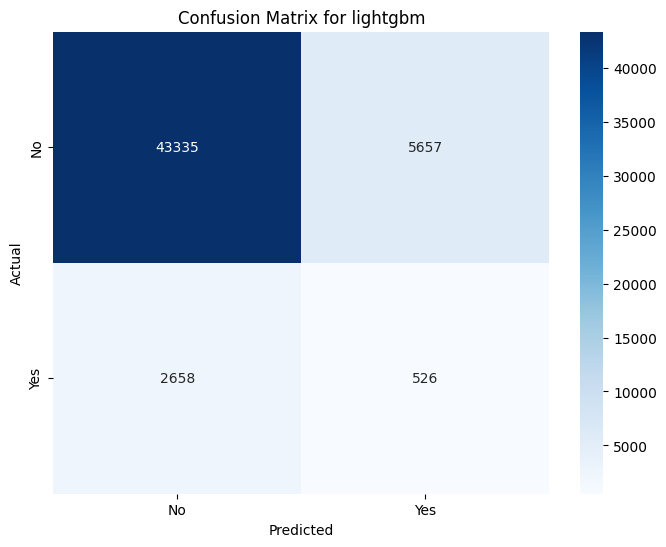

In [29]:
predictor.random_search('lightgbm')
predictor.run_model('lightgbm')

Starting Randomized Search for model 'catboost'...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0:	learn: 0.6871926	total: 170ms	remaining: 16.8s
1:	learn: 0.6822747	total: 206ms	remaining: 10.1s
2:	learn: 0.6779554	total: 243ms	remaining: 7.86s
3:	learn: 0.6739705	total: 282ms	remaining: 6.76s
4:	learn: 0.6707944	total: 319ms	remaining: 6.06s
5:	learn: 0.6682538	total: 356ms	remaining: 5.57s
6:	learn: 0.6659292	total: 397ms	remaining: 5.27s
7:	learn: 0.6636624	total: 434ms	remaining: 4.99s
8:	learn: 0.6618826	total: 470ms	remaining: 4.75s
9:	learn: 0.6605186	total: 507ms	remaining: 4.57s
10:	learn: 0.6593231	total: 546ms	remaining: 4.42s
11:	learn: 0.6577783	total: 589ms	remaining: 4.32s
12:	learn: 0.6564595	total: 628ms	remaining: 4.2s
13:	learn: 0.6549789	total: 672ms	remaining: 4.13s
14:	learn: 0.6538210	total: 708ms	remaining: 4.01s
15:	learn: 0.6530199	total: 745ms	remaining: 3.91s
16:	learn: 0.6518342	total: 784ms	remaining: 3.83s
17:	learn: 0.6510017	total: 820

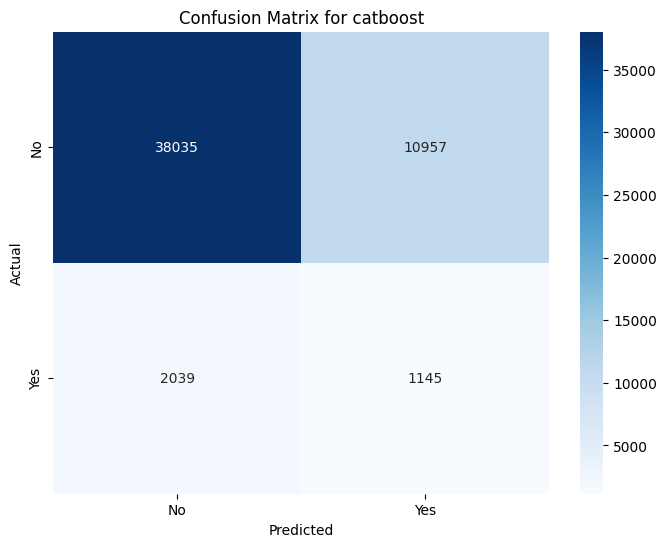

In [30]:
predictor.random_search('catboost')
predictor.run_model('catboost')

## **Threshold approach**

In [31]:
predictor = Predictor(X_train, X_test, Y_train, Y_test)

Starting Randomized Search for model 'random_forest'...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for random_forest: {'n_estimators': 50, 'max_depth': None, 'criterion': 'gini'}
Best Cross-Validation f1: 0.0141
F1 score for threshold 0.1: 0.14670606640013906
F1 score for threshold 0.2: 0.1031555341983021
F1 score for threshold 0.30000000000000004: 0.05211267605633803
F1 score for threshold 0.4: 0.030563002680965148
F1 score for threshold 0.5: 0.013986013986013986
F1 score for threshold 0.6: 0.009060706735125339
F1 score for threshold 0.7000000000000001: 0.004335707649427067
F1 score for threshold 0.8: 0.0
F1 score for threshold 0.9: 0.0
Best threshold for random_forest: 0.1 with F1 score: 0.14670606640013906
Model: random_forest
Config: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': None}
Accuracy: 0.8118291934989267
F1 score: 0.14670606640013906
FNR: 0.7349246231155779


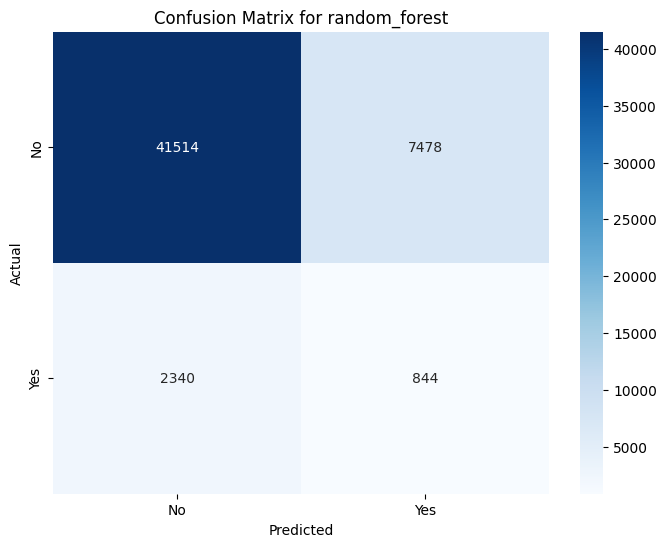

In [32]:
predictor.random_search('random_forest')
predictor.run_model('random_forest', True)

Starting Randomized Search for model 'xgboost'...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for xgboost: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2}
Best Cross-Validation f1: 0.0091
F1 score for threshold 0.1: 0.1493933265925177
F1 score for threshold 0.2: 0.05914396887159533
F1 score for threshold 0.30000000000000004: 0.026392961876832845
F1 score for threshold 0.4: 0.010982306284319707
F1 score for threshold 0.5: 0.005588326606643899
F1 score for threshold 0.6: 0.004370902279113331
F1 score for threshold 0.7000000000000001: 0.002504696305572949
F1 score for threshold 0.8: 0.0018820577164366374
F1 score for threshold 0.9: 0.0006279434850863422
Best threshold for xgboost: 0.1 with F1 score: 0.1493933265925177
Model: xgboost
Config: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 6}
Accuracy: 0.8710134927936216
F1 score: 0.1493933265925177
FNR: 0.8143844221105527


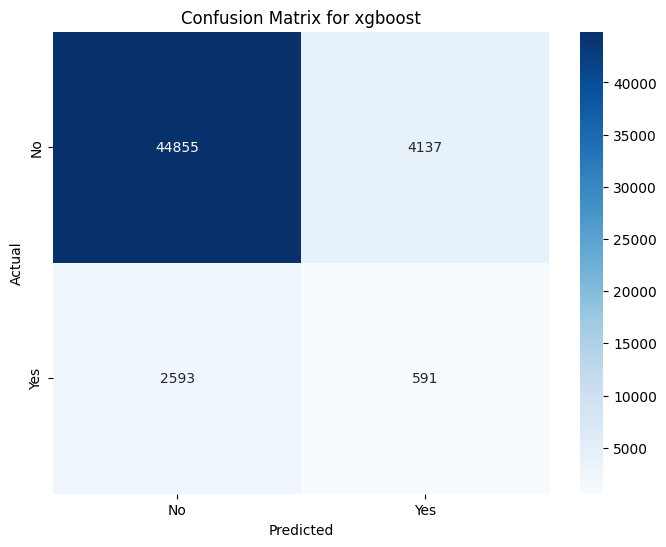

In [33]:
predictor.random_search('xgboost')
predictor.run_model('xgboost', True)

Starting Randomized Search for model 'lightgbm'...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 12768, number of negative: 195920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 208688, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061182 -> initscore=-2.730764
[LightGBM] [Info] Start training from score -2.730764
Best Parameters for lightgbm: {'num_leaves': 63, 'n_estimators': 200, 'learning_rate': 0.2}
Best Cross-Validation f1: 0.0108
[LightGBM] [Info] Number of positive: 12768, number of negative: 195920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006063 seconds.
You can set `force_row_wise=

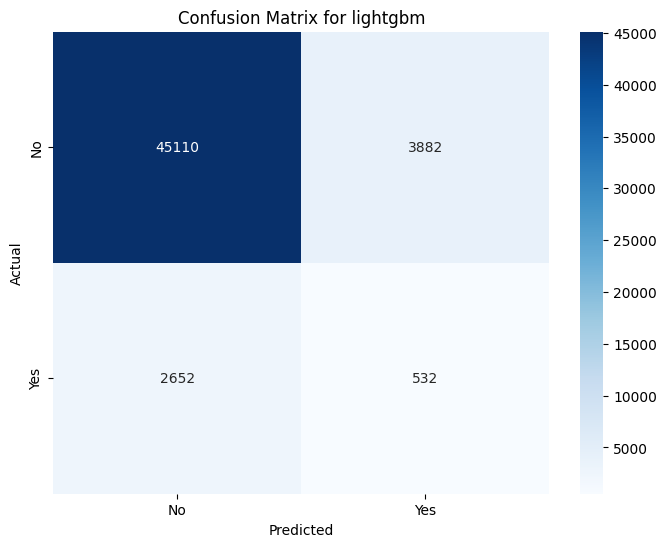

In [34]:
predictor.random_search('lightgbm')
predictor.run_model('lightgbm', True)

Starting Randomized Search for model 'catboost'...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0:	learn: 0.6197112	total: 26.4ms	remaining: 2.61s
1:	learn: 0.5597838	total: 50.2ms	remaining: 2.46s
2:	learn: 0.5101388	total: 74.9ms	remaining: 2.42s
3:	learn: 0.4685676	total: 87.4ms	remaining: 2.1s
4:	learn: 0.4334604	total: 111ms	remaining: 2.11s
5:	learn: 0.4036044	total: 135ms	remaining: 2.12s
6:	learn: 0.3781414	total: 160ms	remaining: 2.13s
7:	learn: 0.3563254	total: 187ms	remaining: 2.15s
8:	learn: 0.3376113	total: 215ms	remaining: 2.17s
9:	learn: 0.3215502	total: 241ms	remaining: 2.17s
10:	learn: 0.3076759	total: 267ms	remaining: 2.16s
11:	learn: 0.2957247	total: 293ms	remaining: 2.15s
12:	learn: 0.2854232	total: 318ms	remaining: 2.13s
13:	learn: 0.2765012	total: 343ms	remaining: 2.1s
14:	learn: 0.2687939	total: 369ms	remaining: 2.09s
15:	learn: 0.2622591	total: 387ms	remaining: 2.03s
16:	learn: 0.2566068	total: 418ms	remaining: 2.04s
17:	learn: 0.2518250	total: 

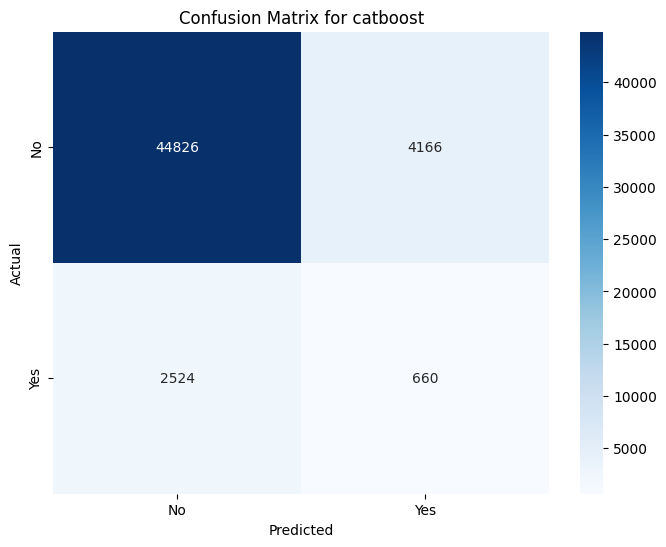

In [35]:
predictor.random_search('catboost')
predictor.run_model('catboost', True)

## **Class Weighting**

In [36]:
predictor = Predictor(X_train, X_test, Y_train, Y_test)

Starting Randomized Search for model 'random_forest'...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for random_forest: {'n_estimators': 200, 'max_depth': 4, 'criterion': 'entropy'}
Best Cross-Validation f1: 0.1669
F1 score for threshold 0.1: 0.11502890173410404
F1 score for threshold 0.2: 0.11502890173410404
F1 score for threshold 0.30000000000000004: 0.11502890173410404
F1 score for threshold 0.4: 0.1401256671846497
F1 score for threshold 0.5: 0.16446939041900535
F1 score for threshold 0.6: 0.14776576867236652
F1 score for threshold 0.7000000000000001: 0.06042936655181553
F1 score for threshold 0.8: 0.004360012457178449
F1 score for threshold 0.9: 0.0
Best threshold for random_forest: 0.5 with F1 score: 0.16446939041900535
Model: random_forest
Config: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 4, 'class_weight': {0: 1, 1: 13}}
Accuracy: 0.754638147807421
F1 score: 0.16446939041900535
FNR: 0.6042713567839196


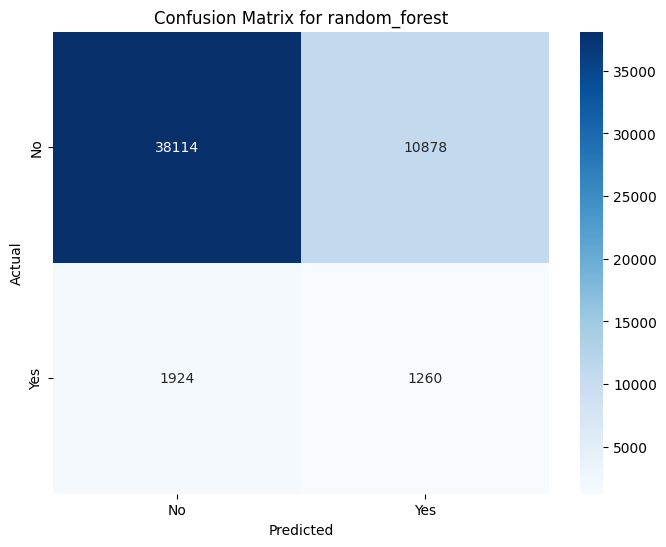

In [37]:
predictor.update_config('random_forest', {'class_weight': {0:1, 1: 13}})
predictor.random_search('random_forest')
predictor.run_model('random_forest', True)

Starting Randomized Search for model 'xgboost'...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for xgboost: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01}
Best Cross-Validation f1: 0.1675
F1 score for threshold 0.1: 0.11502890173410404
F1 score for threshold 0.2: 0.11502890173410404
F1 score for threshold 0.30000000000000004: 0.11502890173410404
F1 score for threshold 0.4: 0.12680577849117175
F1 score for threshold 0.5: 0.16956940635885273
F1 score for threshold 0.6: 0.10200364298724955
F1 score for threshold 0.7000000000000001: 0.0006269592476489029
F1 score for threshold 0.8: 0.0
F1 score for threshold 0.9: 0.0
Best threshold for xgboost: 0.5 with F1 score: 0.16956940635885273
Model: xgboost
Config: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 4, 'scale_pos_weight': 13}
Accuracy: 0.7852460901563938
F1 score: 0.16956940635885273
FNR: 0.6407035175879398


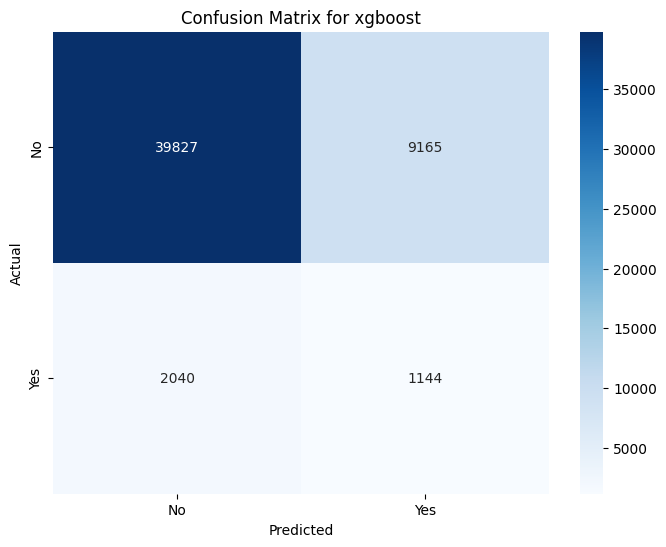

In [38]:
predictor.update_config('xgboost', {'scale_pos_weight': 13})
predictor.random_search('xgboost')
predictor.run_model('xgboost', True)

Starting Randomized Search for model 'lightgbm'...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 12768, number of negative: 195920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 208688, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061182 -> initscore=-2.730764
[LightGBM] [Info] Start training from score -2.730764
Best Parameters for lightgbm: {'num_leaves': 31, 'n_estimators': 50, 'learning_rate': 0.1}
Best Cross-Validation f1: 0.1650
[LightGBM] [Info] Number of positive: 12768, number of negative: 195920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005296 seconds.
You can set `force_row_wise=t

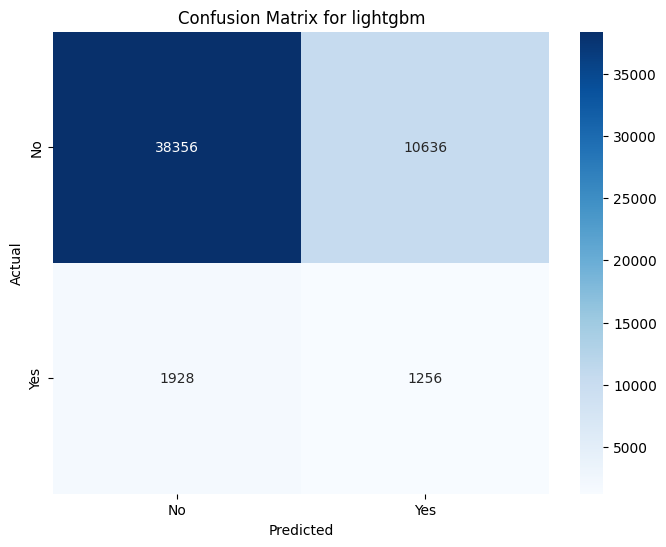

In [39]:
predictor.update_config('lightgbm', {'scale_pos_weight': 13})
predictor.random_search('lightgbm')
predictor.run_model('lightgbm', True)

Starting Randomized Search for model 'catboost'...
Fitting 5 folds for each of 28 candidates, totalling 140 fits
0:	learn: 0.6883556	total: 12.2ms	remaining: 1.21s
1:	learn: 0.6846111	total: 24.9ms	remaining: 1.22s
2:	learn: 0.6811665	total: 36.8ms	remaining: 1.19s
3:	learn: 0.6786338	total: 48.1ms	remaining: 1.16s
4:	learn: 0.6763601	total: 60.5ms	remaining: 1.15s
5:	learn: 0.6743459	total: 73.4ms	remaining: 1.15s
6:	learn: 0.6727593	total: 86.6ms	remaining: 1.15s
7:	learn: 0.6713213	total: 100ms	remaining: 1.15s
8:	learn: 0.6703308	total: 114ms	remaining: 1.15s
9:	learn: 0.6692779	total: 128ms	remaining: 1.15s
10:	learn: 0.6684204	total: 141ms	remaining: 1.14s
11:	learn: 0.6678593	total: 155ms	remaining: 1.14s
12:	learn: 0.6672096	total: 169ms	remaining: 1.13s
13:	learn: 0.6668216	total: 183ms	remaining: 1.12s
14:	learn: 0.6664644	total: 195ms	remaining: 1.1s
15:	learn: 0.6660051	total: 208ms	remaining: 1.09s
16:	learn: 0.6657492	total: 221ms	remaining: 1.08s
17:	learn: 0.6654454	tot

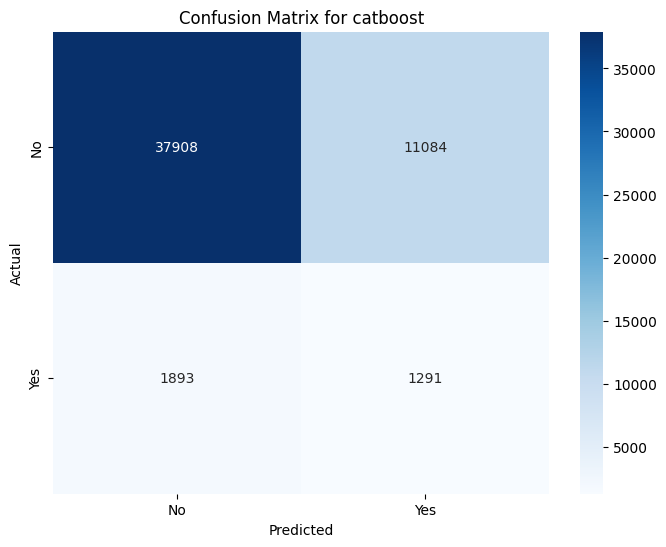

In [40]:
predictor.update_config('catboost', {'scale_pos_weight': 13})
predictor.random_search('catboost')
predictor.run_model('catboost', True)

# **Clustering Model**

In [ ]:
inertia = []
K = range(1, 11) 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_data)
    inertia.append(kmeans.inertia_)

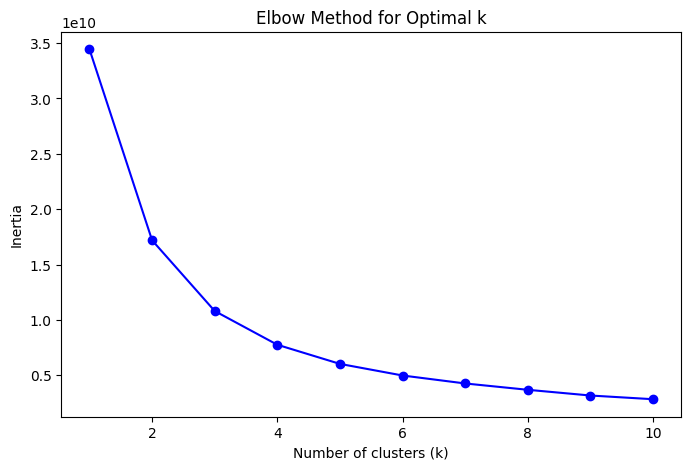

In [51]:
# Plot the Elbow method to determine the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [48]:
# Automatically find the optimal number of clusters (k) using curvature (second derivative approximation)
def find_elbow_point(inertia, K):
    # Compute the first derivative (rate of change of inertia)
    first_derivative = np.diff(inertia)
    # Compute the second derivative (rate of change of the first derivative)
    second_derivative = np.diff(first_derivative)
    # Select k at the point with the highest second derivative (strongest curvature)
    elbow_point = K[1:-1][np.argmax(np.abs(second_derivative))] + 1
    return elbow_point

optimal_k = find_elbow_point(inertia, K)
print(f"Optimal number of clusters (Elbow method): k = {optimal_k}")


Optimal number of clusters (Elbow method): k = 3


In [44]:
kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)
final_data['cluster'] = kmeans.fit_predict(final_data)

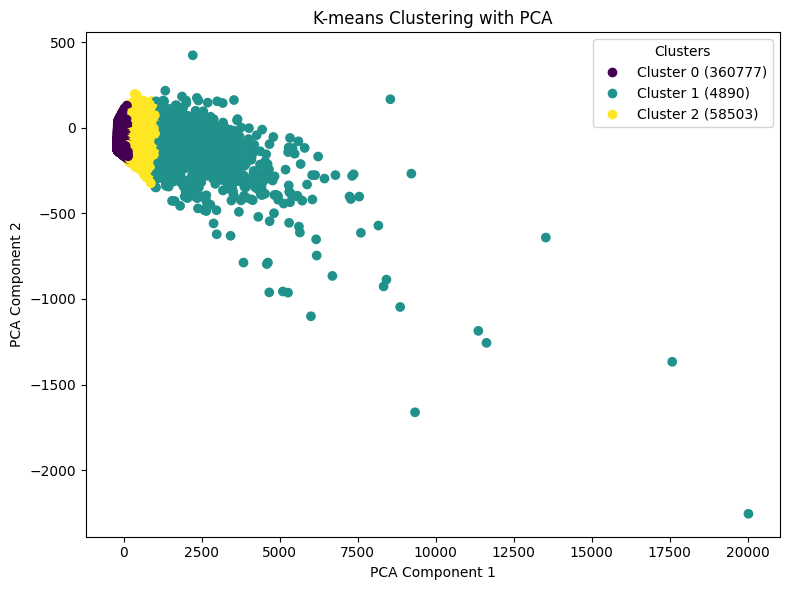

In [49]:
# Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(final_data.drop(columns=['cluster']))

# Create scatter plot colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_data[:, 0], pca_data[:, 1], 
    c=final_data['cluster'], 
    cmap='viridis', 
    label=final_data['cluster']
)

# Generate a legend showing the number of points in each cluster
unique_clusters = final_data['cluster'].unique()
handles = []
labels = []

for cluster_id in sorted(unique_clusters):
    count = (final_data['cluster'] == cluster_id).sum()
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              label=f'Cluster {cluster_id} ({count})',
                              markerfacecolor=plt.cm.viridis(cluster_id / (len(unique_clusters)-1)),
                              markersize=8))
    labels.append(f'Cluster {cluster_id} ({count})')

plt.legend(handles=handles, title="Clusters", loc='best')
plt.title('K-means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()


In [ ]:
# Get the coordinates of the cluster centroids
centroids = kmeans.cluster_centers_

# Create a DataFrame for the centroids, excluding the 'cluster' column from the original data
centroid_df = pd.DataFrame(centroids, columns=final_data.columns[:-1])

# Add a 'cluster' column to indicate the cluster index
centroid_df['cluster'] = range(optimal_k)

centroid_df

,age,sex,job,carrier,marital_status,total_actions,unique_items,unique_categories,unique_brands,unique_merchants,recency_days,active_days,conversion_rate,date_range,add-to-cart,click,favourite,purchase,cluster
0,29.842107,0.304900,27.269127,1.948349,1.166298,75.217333,45.034991,17.766160,23.594939,23.670077,0.999936,12.935959,0.107905,140.116646,0.177613,64.813608,3.913478,6.312634,0
1,32.019427,0.151943,27.131288,1.962781,1.225562,1269.173620,659.601022,75.956237,167.059305,169.883436,0.998773,66.128016,0.022072,175.233742,0.135174,1165.468712,77.452761,26.116973,1
2,31.279707,0.186813,27.296280,1.951921,1.210921,368.780314,212.360932,47.225188,79.154265,80.112970,0.999727,37.129303,0.043522,168.809855,0.205283,332.655555,20.762152,15.157324,2


### **Common Characteristics Across All 3 Clusters**
- Average age is around 31  
- Mostly female users  
- Majority are married  
- Job and carrier are evenly distributed across clusters  

---

### **Cluster 0**
- **Total actions:** ~75 (low)  
- **Active days:** ~13 days  
- **Recency:** Very recent activity (`recency_days ≈ 0.999`)  
- **High conversion rate:** 0.1079 (~10%)  
- **Behavior pattern:** Mostly clicks, few add-to-cart or favourites, but still results in purchases (~6.3 times)

**➡️ Interpretation:**  
This group could represent **"deal hunters"** – users who are not frequently active but tend to purchase immediately when they do visit (possibly during promotions). They show low engagement but high intent.

---

### **Cluster 1**
- **Total actions:** >1269 (very high)  
- **Active days:** ~66 days  
- **Very low conversion rate:** 0.022 (~2%)  
- **Behavior pattern:** Heavy on clicks, low on add-to-cart and favourites, still some purchases (~26 times)

**➡️ Interpretation:**  
This group may correspond to **"window shoppers"** – users who browse a lot, possibly comparing prices or exploring different products/stores, but rarely make purchases.

---

### **Cluster 2**
- **Total actions:** ~368  
- **Active days:** ~37 days  
- **Moderate conversion rate:** ~4.3%  
- **Purchases:** ~15 times  
- **Behavior pattern:** Balanced interaction across click, add-to-cart, and favourite

**➡️ Interpretation:**  
This cluster likely represents **loyal customers** – users with consistent and moderate interaction, making purchases regularly based on real needs or habitual behavior.

In [47]:
final_data.to_csv('data_clustering/segment.csv', index=False)